## GPUではなくCPUで実施
Docker-compose.yamlのDeployの記述を削除

In [1]:
import numpyro
import numpyro.distributions as dist

import jax
import arviz as az

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

/root/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
jax.devices()

2022-09-18 03:11:57.139925: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-09-18 03:11:57.139955: W external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)


[CpuDevice(id=0)]

In [3]:
numpyro.set_platform('cpu')
numpyro.set_host_device_count(4)

In [5]:
data = pd.DataFrame({   
    'yield':[7, 13, 13, 11, 5, 6, 8, 11, 10, 11,
             11, 11, 11, 14, 8, 15, 10, 9, 13, 12,
             8, 15, 7, 11, 5, 11, 15, 10, 13, 9,
             8, 12, 13, 6, 8, 5, 13, 8, 5, 10,
             18, 9, 7, 12, 11, 5, 9, 10, 13, 13,
             7, 12, 8, 16, 10, 6, 12, 13, 10, 12, 
             9, 7, 12, 11, 8, 15, 13, 11, 9, 17,
             11, 10, 15, 19 ,11, 13, 12, 9, 10,10],

    'group':[0,0,0,0,0,0,0,0,0,0,
             0,0,0,0,0,0,0,0,0,0,
             0,0,0,0,0,0,0,0,0,0,
             0,0,0,0,0,0,0,0,0,0,
             0,0,0,0,0,0,0,0,0,0,
             1,1,1,1,1,1,1,1,1,1,
             1,1,1,1,1,1,1,1,1,1,
             1,1,1,1,1,1,1,1,1,1,
             ]    
})

In [9]:
y = data[data['group']==0]['yield'].values

In [6]:
def model(y=None, num_data=0):
    #パラメータの事前分布の定義
    mu = numpyro.sample('mu', dist.HalfNormal(10))
    
    #観測データに基づく尤度の定義
    with numpyro.plate('data', num_data):
        
        numpyro.sample('obs', dist.Poisson(mu), obs=y)

In [7]:
nuts = numpyro.infer.NUTS(model)
mcmc = numpyro.infer.MCMC(nuts, num_warmup=500, num_samples=3000, num_chains=4)

/tmp/ipykernel_31/714539352.py:2: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = numpyro.infer.MCMC(nuts, num_warmup=500, num_samples=3000, num_chains=4)


### CPUモードでMCMC　GPUより20秒くらいはやい

In [10]:
mcmc.run(jax.random.PRNGKey(0), y=y, num_data=len(y))
mcmc.samples = mcmc.get_samples()

sample: 100% 3500/3500 [00:03<00:00, 1163.73it/s, 3 steps of size 1.17e+00. acc. prob=0.91]
sample: 100% 3500/3500 [00:01<00:00, 1820.53it/s, 1 steps of size 1.27e+00. acc. prob=0.91]
sample: 100% 3500/3500 [00:01<00:00, 1813.97it/s, 1 steps of size 9.03e-01. acc. prob=0.94]
sample: 100% 3500/3500 [00:01<00:00, 1816.04it/s, 3 steps of size 1.19e+00. acc. prob=0.91]


In [11]:
idata = az.from_numpyro(mcmc)

array([[<AxesSubplot: title={'center': 'mu'}>,
        <AxesSubplot: title={'center': 'mu'}>]], dtype=object)

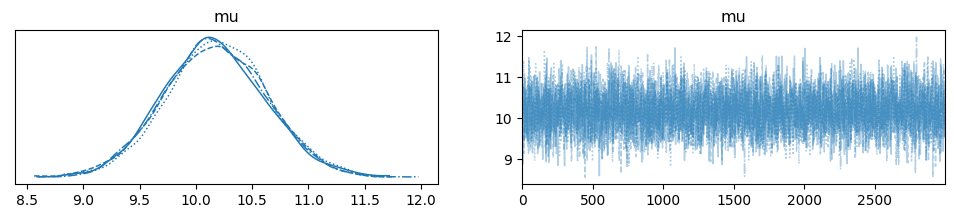

In [12]:
az.plot_trace(idata)

In [13]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,10.176,0.452,9.305,11.009,0.007,0.005,4721.0,6315.0,1.0


<AxesSubplot: title={'center': 'mu'}>

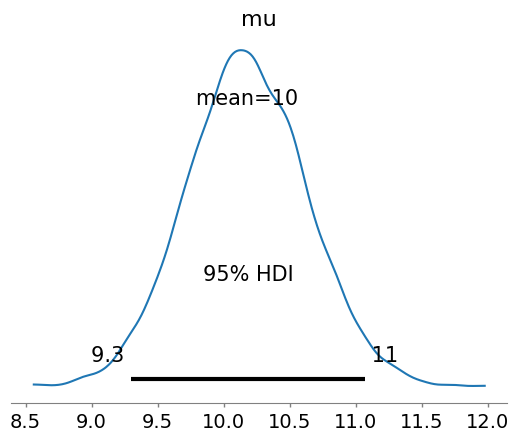

In [14]:
az.plot_posterior(idata, hdi_prob=0.95)